files/folders I uploaded to the server:

- drug_review_w2v.model.zip (need to unzip)
- drugsComTest_raw.tsv
- drugsComTrain_raw.tsv

In [ ]:
!unzip drug_review_w2v.model.zip

Archive:  drug_review_w2v.model.zip
  inflating: drug_review_w2v.model   


In [ ]:
!pip install gensim --upgrade
import gensim
print(gensim.__version__)

     |████████████████████████████████| 24.1 MB 64.6 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
4.1.2


In [ ]:
import pandas as pd
import numpy as np
# import Utils
import tensorflow as tf
import keras
import pickle
import seaborn as sn
import matplotlib.pyplot as plt

from sklearn.utils import class_weight
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from gensim.models import Word2Vec
from gensim.models.keyedvectors import KeyedVectors

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint
from keras.layers.merge import Concatenate
from keras.layers import Dense, Input, GlobalMaxPooling1D, GlobalAveragePooling1D, Flatten, Dropout
from keras.layers import LSTM, Bidirectional, Conv1D, MaxPooling1D, Embedding, Reshape
from keras.layers.merge import Concatenate
from keras.models import Model, load_model
# from keras.utils import to_categorical, plot_model
# from keras.backend.tensorflow_backend import set_session
from tensorflow.keras.utils import to_categorical
from tensorflow.compat.v1.keras.backend import set_session

import nltk
nltk.download('stopwords') 

from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
import unicodedata
import re
import gc

# import Utils.data_utils as data
# import Utils.metric_utils as mtric

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
gpu = tf.config.experimental.list_physical_devices('GPU')[0]
tf.config.experimental.set_memory_growth(gpu, True)

## Preparing our dataset

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [ ]:
loaded_train_df = pd.read_csv('drugsComTrain_raw.tsv', sep='\t')
df = loaded_train_df

def get_sentiment(rating):
  if rating < 4.0:
    return 'neg'
  elif rating >= 4.0 and rating <= 7.0:
    return 'neutral'
  else:
    return 'pos'

df['sentiment'] = df['rating'].map(lambda x: get_sentiment(x))

# encode class names to integers
labelencoder = preprocessing.LabelEncoder()
df['sentiment_encoded'] = labelencoder.fit_transform(df['sentiment'])

X_train, X_val, y_train, y_val = train_test_split(df['review'], df['sentiment_encoded'], train_size=0.8, random_state=1)

In [ ]:
loaded_test_df = pd.read_csv('drugsComTest_raw.tsv', sep='\t')
test_df = loaded_test_df[:2000]

test_df['sentiment'] = test_df['rating'].map(lambda x: get_sentiment(x))
labelencoder = preprocessing.LabelEncoder()
test_df['sentiment_encoded'] = labelencoder.fit_transform(test_df['sentiment'])
X_test = test_df['review']
y_test = test_df['sentiment_encoded']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(129037,)
(32260,)
(2000,)


In [ ]:
test_df['sentiment'].value_counts()

pos        1206
neg         446
neutral     348
Name: sentiment, dtype: int64

In [ ]:
df['sentiment'].value_counts()

pos        97410
neg        35063
neutral    28824
Name: sentiment, dtype: int64

In [ ]:
df['review']

0         "It has no side effect, I take it in combinati...
1         "My son is halfway through his fourth week of ...
2         "I used to take another oral contraceptive, wh...
3         "This is my first time using any form of birth...
4         "Suboxone has completely turned my life around...
                                ...                        
161292    "I wrote my first report in Mid-October of 201...
161293    "I was given this in IV before surgey. I immed...
161294    "Limited improvement after 4 months, developed...
161295    "I&#039;ve been on thyroid medication 49 years...
161296    "I&#039;ve had chronic constipation all my adu...
Name: review, Length: 161297, dtype: object

### Tokenize and pad data

In [ ]:
MAX_NB_WORDS = 20000  # 300000
EMBEDDING_DIM = 100  # 300
MAX_SEQUENCE_LENGTH = 30  # 250

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(df['review'])

In [ ]:
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_dev = tokenizer.texts_to_sequences(X_val)
sequences_test = tokenizer.texts_to_sequences(X_test)

Xtrain = pad_sequences(sequences_train, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='pre')
Xdev = pad_sequences(sequences_dev, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='pre')
Xtest = pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='pre')
ytrain = to_categorical(y_train.values)
ydev = to_categorical(y_val.values)
ytest = to_categorical(y_test.values)

del sequences_dev, sequences_train, sequences_test
gc.collect()

0

## Model

In [ ]:
class Metrics(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.f1s = 0
    def on_epoch_end(self, batch, logs={}):
        predict = np.asarray(self.model.predict(self.validation_data[0])).argmax(axis=1)
        targ = self.validation_data[1].argmax(axis=1)
        #f1 = f1_score(targ, predict, average='micro')
        mtrcs = precision_recall_fscore_support(targ, predict, average='macro')
        print ("\nPrecision: "+str(mtrcs[0])+"\tRecall: "+str(mtrcs[1])+"\tF1: "+str(mtrcs[2]))
        if (self.f1s < mtrcs[2]):
            self.f1s = mtrcs[2]
        return
    

def build_model(rand_embed, w2v_trainable=False):
    num_words = len(tokenizer.word_index)+1

    if rand_embed:
        embedding_matrix = np.zeros((num_words, EMBEDDING_DIM), dtype=np.float32)
        embedding_layer = Embedding(num_words, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH)
    else:
        w2v_model = Word2Vec.load('drug_review_w2v.model')
        embedding_matrix = np.random.uniform(-0.05, 0.05, size=(len(tokenizer.word_index)+1, EMBEDDING_DIM))
        for word, i in tokenizer.word_index.items():
            try:
                embedding_vector = w2v_model.wv[word]
            except KeyError:
                embedding_vector = None
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector

        embedding_layer = Embedding(num_words,
                                    EMBEDDING_DIM,
                                    weights=[embedding_matrix],
                                    input_length=MAX_SEQUENCE_LENGTH,
                                    trainable=w2v_trainable)

    # class_W = class_weight.compute_class_weight('balanced', np.unique(np.asarray(df_train.label)), np.asarray(df_train.label))
    # class_weight_dict = dict(enumerate(class_W))

    # ---- Model layers ----
    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,))

    embedded_sequences = embedding_layer(sequence_input)
    drop_out_rate = 0.3
    drop_out_1 = Dropout(drop_out_rate, name='drop_out_1')(embedded_sequences)

    biLSTM_1 = Bidirectional(LSTM(250, return_sequences=True))(drop_out_1)

    conv_1 = Conv1D(64, 2, activation='relu', name='conv_1')(biLSTM_1)
    gmp_1 = GlobalMaxPooling1D(name='gmp_1')(conv_1)
    conv_2 = Conv1D(64, 3, activation='relu', name='conv_2')(biLSTM_1)
    gmp_2 = GlobalMaxPooling1D(name='gmp_2')(conv_2)
    conv_3 = Conv1D(64, 5, activation='relu', name='conv_3')(biLSTM_1)
    gmp_3 = GlobalMaxPooling1D(name='gmp_3')(conv_3)

    concat = Concatenate()([gmp_1,gmp_2,gmp_3])
    drop_out_2 = Dropout(drop_out_rate, name='drop_out_2')(concat)
    mp_dense = Dense(128, activation='relu', name='mp_dense')(drop_out_2)
    preds = Dense(3, activation='softmax', name='preds')(mp_dense)
    LSTM_CNN_model = Model(sequence_input, preds)

    LSTM_CNN_model.compile(loss='categorical_crossentropy',
                optimizer='Adam',
                metrics=['accuracy'])
    
    metrics = Metrics()

    callbacks_list = [metrics]

    return LSTM_CNN_model, callbacks_list

In [ ]:
BATCH_SIZE = 256
N_EPOCHS = 50

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_accuracy', mode='max',
                               patience=2, restore_best_weights=True,
                               min_delta=0.001)

In [ ]:
def evaluate_model(model_obj, dataset='val'):
    print(dataset)
    if dataset == 'val':
      model_pred = model_obj.predict(Xdev, batch_size=16)
      y_eval_labels = np.argmax(ydev, axis=1)
    elif dataset == 'test':
      model_pred = model_obj.predict(Xtest, batch_size=16)
      y_eval_labels = np.argmax(ytest, axis=1)

    model_pred_labels = np.argmax(model_pred, axis=1)

    print(classification_report(y_eval_labels, model_pred_labels, target_names=labelencoder.classes_))

# Models with different embeddings

### Model with randomly initialize embeddings

In [ ]:
LSTM_CNN_model_rand_embed, callbacks_list = build_model(rand_embed=True)

history = LSTM_CNN_model_rand_embed.fit(Xtrain, ytrain,
      shuffle=True,
      batch_size=BATCH_SIZE,
      epochs=N_EPOCHS,
      callbacks=[early_stopping],
      validation_data=(Xdev, ydev))

Epoch 1/50
505/505 [==============================] - 68s 104ms/step - loss: 0.7504 - accuracy: 0.6830 - val_loss: 0.6783 - val_accuracy: 0.7119
Epoch 2/50
505/505 [==============================] - 51s 101ms/step - loss: 0.6338 - accuracy: 0.7341 - val_loss: 0.6486 - val_accuracy: 0.7282
Epoch 3/50
505/505 [==============================] - 51s 101ms/step - loss: 0.5694 - accuracy: 0.7649 - val_loss: 0.6346 - val_accuracy: 0.7401
Epoch 4/50
505/505 [==============================] - 51s 101ms/step - loss: 0.5083 - accuracy: 0.7931 - val_loss: 0.6454 - val_accuracy: 0.7437
Epoch 5/50
505/505 [==============================] - 51s 101ms/step - loss: 0.4560 - accuracy: 0.8157 - val_loss: 0.6373 - val_accuracy: 0.7521
Epoch 6/50
505/505 [==============================] - 51s 101ms/step - loss: 0.4108 - accuracy: 0.8352 - val_loss: 0.6693 - val_accuracy: 0.7638
Epoch 7/50
505/505 [==============================] - 51s 101ms/step - loss: 0.3703 - accuracy: 0.8517 - val_loss: 0.6932 - val_ac

In [ ]:
evaluate_model(LSTM_CNN_model_rand_embed)

              precision    recall  f1-score   support

         neg       0.76      0.70      0.73       446
     neutral       0.54      0.48      0.51       348
         pos       0.86      0.91      0.88      1206

    accuracy                           0.79      2000
   macro avg       0.72      0.70      0.71      2000
weighted avg       0.78      0.79      0.78      2000



### Model with pretrained w2v embeddings

In [ ]:
LSTM_CNN_model_w2v_untrainable, callbacks_list_w2v_untrainable = build_model(rand_embed=False, w2v_trainable=False)

LSTM_CNN_model_w2v_untrainable.fit(Xtrain, ytrain,
      shuffle=True,
      batch_size=BATCH_SIZE,
      epochs=N_EPOCHS,
      callbacks=[early_stopping],
      validation_data=(Xdev, ydev))

Epoch 1/50
505/505 [==============================] - 52s 95ms/step - loss: 0.9094 - accuracy: 0.6115 - val_loss: 0.8480 - val_accuracy: 0.6404
Epoch 2/50
505/505 [==============================] - 47s 93ms/step - loss: 0.8302 - accuracy: 0.6414 - val_loss: 0.8227 - val_accuracy: 0.6576
Epoch 3/50
505/505 [==============================] - 47s 93ms/step - loss: 0.7994 - accuracy: 0.6561 - val_loss: 0.7729 - val_accuracy: 0.6684
Epoch 4/50
505/505 [==============================] - 47s 93ms/step - loss: 0.7809 - accuracy: 0.6636 - val_loss: 0.7687 - val_accuracy: 0.6779
Epoch 5/50
505/505 [==============================] - 47s 93ms/step - loss: 0.7673 - accuracy: 0.6714 - val_loss: 0.7494 - val_accuracy: 0.6840
Epoch 6/50
505/505 [==============================] - 47s 93ms/step - loss: 0.7536 - accuracy: 0.6764 - val_loss: 0.7447 - val_accuracy: 0.6906
Epoch 7/50
505/505 [==============================] - 47s 93ms/step - loss: 0.7430 - accuracy: 0.6822 - val_loss: 0.7293 - val_accuracy:

In [ ]:
evaluate_model(LSTM_CNN_model_w2v_untrainable)

              precision    recall  f1-score   support

         neg       0.59      0.59      0.59       446
     neutral       0.47      0.08      0.13       348
         pos       0.74      0.92      0.82      1206

    accuracy                           0.70      2000
   macro avg       0.60      0.53      0.52      2000
weighted avg       0.66      0.70      0.65      2000



### Model with trainable w2v embeddings

In [ ]:
LSTM_CNN_model_w2v_trainable, callbacks_list_w2v_trainable = build_model(rand_embed=False, w2v_trainable=True)

LSTM_CNN_model_w2v_trainable.fit(Xtrain, ytrain,
      shuffle=True,
      batch_size=BATCH_SIZE,
      epochs=N_EPOCHS,
      callbacks=[early_stopping],
      validation_data=(Xdev, ydev))
evaluate_model(LSTM_CNN_model_w2v_trainable)

Epoch 1/50
505/505 [==============================] - 43s 75ms/step - loss: 0.7598 - accuracy: 0.6753 - val_loss: 0.6917 - val_accuracy: 0.7064
Epoch 2/50
505/505 [==============================] - 36s 71ms/step - loss: 0.6757 - accuracy: 0.7144 - val_loss: 0.6531 - val_accuracy: 0.7244
Epoch 3/50
505/505 [==============================] - 36s 72ms/step - loss: 0.6246 - accuracy: 0.7374 - val_loss: 0.6334 - val_accuracy: 0.7318
Epoch 4/50
505/505 [==============================] - 36s 72ms/step - loss: 0.5788 - accuracy: 0.7580 - val_loss: 0.6141 - val_accuracy: 0.7455
Epoch 5/50
505/505 [==============================] - 36s 71ms/step - loss: 0.5336 - accuracy: 0.7792 - val_loss: 0.6017 - val_accuracy: 0.7536
Epoch 6/50
505/505 [==============================] - 36s 72ms/step - loss: 0.4899 - accuracy: 0.7986 - val_loss: 0.5809 - val_accuracy: 0.7669
Epoch 7/50
505/505 [==============================] - 36s 71ms/step - loss: 0.4425 - accuracy: 0.8194 - val_loss: 0.5826 - val_accuracy:

### Final model evaluation

In [ ]:
evaluate_model(LSTM_CNN_model_w2v_trainable, dataset='test')

## Plot and save model

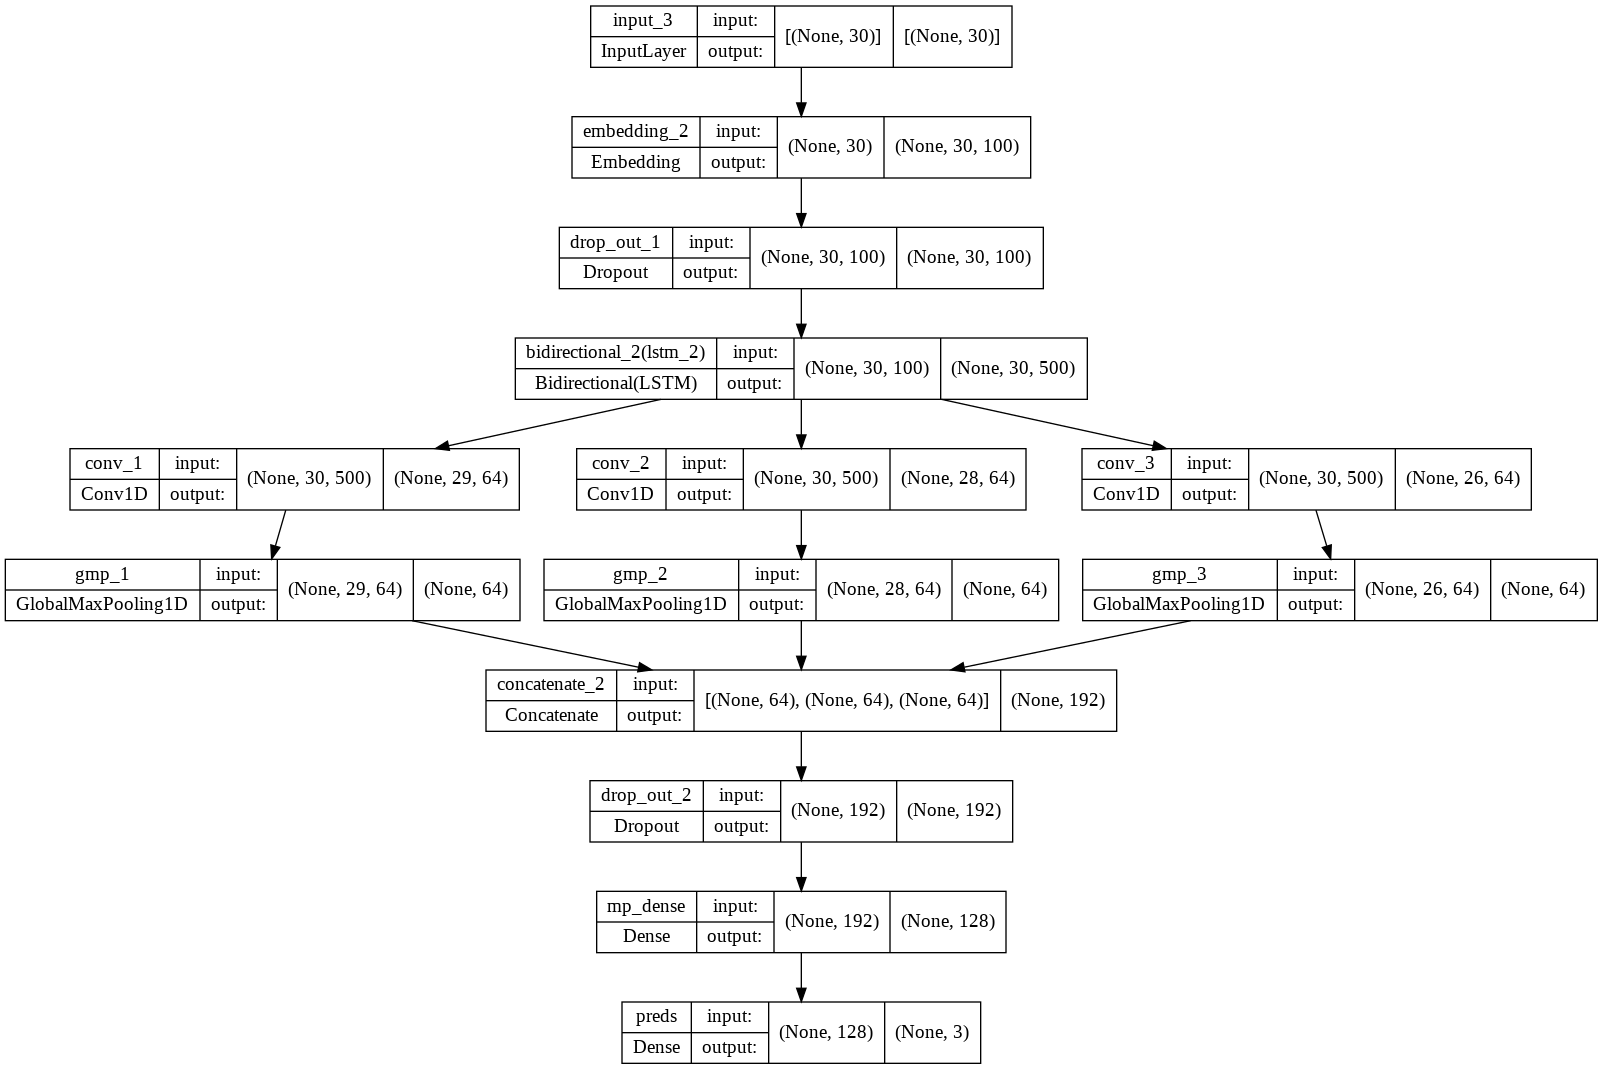

In [ ]:
img_file = 'LSTM_CNN_model_w2v_trainable.png'
tf.keras.utils.plot_model(LSTM_CNN_model_w2v_trainable, to_file=img_file , show_shapes=True)

In [ ]:
LSTM_CNN_model_w2v_trainable.save('LSTM_CNN_model_w2v_trainable')
!zip -r LSTM_CNN_model_w2v_trainable.zip LSTM_CNN_model_w2v_trainable

from google.colab import drive
drive.mount('/content/drive')

!cp LSTM_CNN_model_w2v_trainable.zip "/content/drive/My Drive/LSTM_CNN_model_w2v_trainable.zip"

from google.colab import files
files.download('LSTM_CNN_model_w2v_trainable.zip')

INFO:tensorflow:Assets written to: LSTM_CNN_model_w2v_trainable/assets


INFO:tensorflow:Assets written to: LSTM_CNN_model_w2v_trainable/assets


  adding: LSTM_CNN_model_w2v_trainable/ (stored 0%)
  adding: LSTM_CNN_model_w2v_trainable/variables/ (stored 0%)
  adding: LSTM_CNN_model_w2v_trainable/variables/variables.data-00000-of-00001 (deflated 40%)
  adding: LSTM_CNN_model_w2v_trainable/variables/variables.index (deflated 68%)
  adding: LSTM_CNN_model_w2v_trainable/assets/ (stored 0%)
  adding: LSTM_CNN_model_w2v_trainable/keras_metadata.pb (deflated 92%)
  adding: LSTM_CNN_model_w2v_trainable/saved_model.pb (deflated 90%)
Mounted at /content/drive


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
loaded_model = tf.keras.models.load_model('LSTM_CNN_model_w2v_trainable')
evaluate_model(loaded_model)

              precision    recall  f1-score   support

         neg       0.76      0.72      0.74       446
     neutral       0.59      0.54      0.56       348
         pos       0.86      0.90      0.88      1206

    accuracy                           0.80      2000
   macro avg       0.74      0.72      0.73      2000
weighted avg       0.79      0.80      0.79      2000

